In [1]:
#CW
import torch
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.autograd.gradcheck import zero_gradients
import torch.utils.data.dataloader as Data
import torch.nn as nn
from torchvision import models
import numpy as np
import cv2
from tools import show_images_diff

In [2]:
#获取计算设备 默认是CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#图像加载以及预处理
image_path="../picture/cow.jpeg"
orig = cv2.imread(image_path)[..., ::-1]
orig = cv2.resize(orig, (224, 224))
img = orig.copy().astype(np.float32)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img /= 255.0
img = (img - mean) / std
img = img.transpose(2, 0, 1)

img=np.expand_dims(img, axis=0)

print(img.shape)

#使用预测模式 主要影响droupout和BN层的行为
model = models.alexnet(pretrained=True).to(device).eval()


(1, 3, 224, 224)


In [3]:
#adam的最大迭代次数 论文中建议10000次 测试阶段1000也可以 1000次可以完成95%的优化工作
max_iterations=1000
#adam学习速率
learning_rate=0.01
#二分查找最大次数
binary_search_steps=10
#c的初始值
initial_const=1e2
confidence=initial_const

#k值
k=40

#像素值区间
boxmin = -3.0
boxmax = 3.0

#类别数 pytorch的实现里面是1000
num_labels=1000

#攻击目标标签 必须使用one hot编码
target_label=288
tlab=Variable(torch.from_numpy(np.eye(num_labels)[target_label]).to(device).float())


print()

shape = (1,3,224,224)


In [4]:


#c的初始化边界
lower_bound = 0
c=initial_const
upper_bound = 1e10

# the best l2, score, and image attack
o_bestl2 = 1e10
o_bestscore = -1
o_bestattack = [np.zeros(shape)]



In [5]:
# the resulting image, tanh'd to keep bounded from boxmin to boxmax
boxmul = (boxmax - boxmin) / 2.
boxplus = (boxmin + boxmax) / 2.

for outer_step in range(binary_search_steps):
    print("o_bestl2={} confidence={}".format(o_bestl2,confidence)  )
    
    #把原始图像转换成图像数据和扰动的形态
    timg = Variable(torch.from_numpy(np.arctanh((img - boxplus) / boxmul * 0.999999)).to(device).float())
    modifier=Variable(torch.zeros_like(timg).to(device).float())
    

    #设置为不保存梯度值 自然也无法修改
    #for param in model.parameters():
    #    param.requires_grad = False
        
    #图像数据的扰动量梯度可以获取
    modifier.requires_grad = True
    

    #定义优化器 仅优化modifier
    optimizer = torch.optim.Adam([modifier],lr=learning_rate)
    
    for iteration in range(1,max_iterations+1):
        optimizer.zero_grad()
        
        #定义新输入
        newimg = torch.tanh(modifier + timg) * boxmul + boxplus
      
        output=model(newimg)
             
        #定义cw中的损失函数
        
        #l2范数
        #l2dist = tf.reduce_sum(tf.square(newimg-(tf.tanh(timg) * boxmul + boxplus)),[1,2,3])
        #loss2 = tf.reduce_sum(l2dist)
        loss2=torch.dist(newimg,(torch.tanh(timg) * boxmul + boxplus),p=2)
        
        """
        # compute the probability of the label class versus the maximum other
            real = tf.reduce_sum((tlab)*output,1)
            # 论文中的开源实现 other = tf.reduce_max((1-tlab)*output - (tlab*10000),1)
            other = tf.reduce_max((1-tlab)*output)
            loss1 = tf.maximum(0.0, other-real+k)
            loss1 = tf.reduce_sum(const*loss1)
        """
               
        real=torch.max(output*tlab)
        other=torch.max((1-tlab)*output)  
        loss1=other-real+k   
        loss1=torch.clamp(loss1,min=0)
             
        loss1=confidence*loss1
           
        loss=loss1+loss2
        
            
        loss.backward(retain_graph=True)

        optimizer.step()
              
        l2=loss2
        
        sc=output.data.cpu().numpy()
        
        # print out the losses every 10%
        if iteration%(max_iterations//10) == 0:
            print("iteration={} loss={} loss1={} loss2={}".format(iteration,loss,loss1,loss2))
              
        if (l2 < o_bestl2) and (np.argmax(sc) == target_label  ):
            print("attack success l2={} target_label={}".format(l2,target_label))
            o_bestl2 = l2
            o_bestscore = np.argmax(sc)
            o_bestattack = newimg.data.cpu().numpy()
            
    confidence_old=-1       
    if (o_bestscore == target_label) and o_bestscore != -1:
        #攻击成功 减小c
        upper_bound = min(upper_bound,confidence)
        if upper_bound < 1e9:
                print()
                confidence_old=confidence
                confidence = (lower_bound + upper_bound)/2
    else:
        lower_bound = max(lower_bound,confidence)
        confidence_old=confidence
        if upper_bound < 1e9:
                confidence = (lower_bound + upper_bound)/2
        else:
                confidence *= 10
                
    print("outer_step={} confidence {}->{}".format(outer_step,confidence_old,confidence))

o_bestl2=10000000000.0 confidence=100.0
attack success l2=41.4673957824707 target_label=288
iteration=100 loss=107.25787353515625 loss1=0.0 loss2=107.25787353515625
iteration=200 loss=110.32181549072266 loss1=0.0 loss2=110.32181549072266
iteration=300 loss=95.73548889160156 loss1=0.0 loss2=95.73548889160156
iteration=400 loss=114.7618408203125 loss1=0.0 loss2=114.7618408203125
iteration=500 loss=129.7127227783203 loss1=0.0 loss2=129.7127227783203
iteration=600 loss=113.28498840332031 loss1=0.0 loss2=113.28498840332031
iteration=700 loss=96.13314819335938 loss1=0.0 loss2=96.13314819335938
iteration=800 loss=126.3227767944336 loss1=0.0 loss2=126.3227767944336
iteration=900 loss=130.9044189453125 loss1=0.0 loss2=130.9044189453125
iteration=1000 loss=110.85984802246094 loss1=0.0 loss2=110.85984802246094

outer_step=0 confidence 100.0->50.0
o_bestl2=41.4673957824707 confidence=50.0
attack success l2=39.109554290771484 target_label=288
iteration=100 loss=105.87308502197266 loss1=0.0 loss2=10

iteration=500 loss=21.66114044189453 loss1=13.844840049743652 loss2=7.816301345825195
iteration=600 loss=21.207347869873047 loss1=13.445316314697266 loss2=7.762031078338623
iteration=700 loss=21.472227096557617 loss1=13.986891746520996 loss2=7.485334873199463
iteration=800 loss=21.07838249206543 loss1=13.512225151062012 loss2=7.566157817840576
iteration=900 loss=21.337932586669922 loss1=13.817378997802734 loss2=7.520554542541504
iteration=1000 loss=21.57647705078125 loss1=13.782630920410156 loss2=7.793846130371094

outer_step=8 confidence 0.390625->0.1953125
o_bestl2=6.353428840637207 confidence=0.1953125
iteration=100 loss=11.907797813415527 loss1=9.742632865905762 loss2=2.1651651859283447
iteration=200 loss=11.844062805175781 loss1=10.119562149047852 loss2=1.7245005369186401
iteration=300 loss=11.848462104797363 loss1=10.304091453552246 loss2=1.5443702936172485
iteration=400 loss=12.11383056640625 loss1=10.405445098876953 loss2=1.7083849906921387
iteration=500 loss=11.796277046203613

In [8]:
print(o_bestattack.shape)
print(img.shape)

(1, 3, 224, 224)
(1, 3, 224, 224)


(3, 224, 224)
l0=90441 l2=69825.06902252228


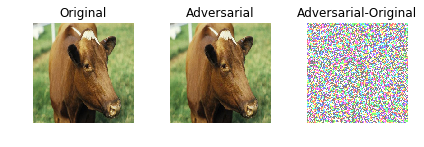

In [12]:
adv=o_bestattack[0]
print(adv.shape)
adv = adv.transpose(1, 2, 0)
adv = (adv * std) + mean
adv = adv * 255.0
adv = np.clip(adv, 0, 255).astype(np.uint8)

show_images_diff(orig,0,adv,0)